#  MelodyMaster
## Notebook02 - Representations, Metrics and kNN
### Idan Kashani & Or Raphael Bidusa

# Welcome Back!
Today we shall build our first classifier, using the already preprocessed data from part 1.
Make sure to run part 1 in order to get the right csv files, you can run `01 - script.py` instead of the notebook itself.

In [144]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import ast
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
np.random.seed(42)

First, we will load the dataset and split it to training set and validation set.

In [145]:
df = pd.read_csv('../train.csv')
lyrics = df['lyrics']
artists = df['artist']
all_but_artists = df[['lyrics','song_name','url','words count','unique words count']]

X_train, X_val, y_train, y_val = train_test_split(all_but_artists, artists, test_size=0.15, stratify=artists, random_state=42)

# Save to CSV
train_df = pd.DataFrame(np.c_[ X_train,y_train], columns = ['lyrics','song_name','url','words count','unique words count','artist'])
val_df = pd.DataFrame(np.c_[ X_val,y_val], columns = ['lyrics','song_name','url','words count','unique words count','artist'])
print(f'train shape: {train_df.shape}, validation shape: {val_df.shape}')

train shape: (7221, 6), validation shape: (1275, 6)


## Vocabulary is Key
Each song in our dataset will be represented and embedded in three different ways, Bag-of-Words, Set-of-Words and TF-IDF.
In order to create these representations we need to work with a *vocabulary* - a set of all the words in the training set.

In [146]:
train_df['lyrics_as_list'] = train_df['lyrics'].map(lambda l: set(ast.literal_eval(str(l))))
vocabulary = list(sorted(set.union(*train_df['lyrics_as_list'].tolist())))
print(vocabulary)
print(f"Vocabulary length is: {len(vocabulary)}")

["'א", "'אבי", "'אבל'", "'אוי", "'איגן'", "'אל", "'אמא", "'אנא", "'אנחנו", "'אני", "'בוא'", "'בואי", "'בואי'", "'בוואלה'", "'בטיח", "'בעד", "'בעד'", "'בראבו'", "'ה", "'הבן", "'הגדולה'", "'הו", "'הוא", "'השיר", "'זה", "'חד", "'חפף", "'חריסולה'", "'חת", "'טוב", "'טיליגנטי", "'יהי", "'ילדי", "'כוכב", "'כי", "'כן'", "'כנס", "'לא", "'לבלות'", "'לימלך", "'לכה", "'מונאמי'", "'נגד'", "'ני", "'נתגבר", "'סה", "'סחתן'", "'סתובבתי", "'סתכל", "'סתכלי", "'סתכלים", "'עגלה", "'עוד", "'על", "'ענני", "'פירסט", "'צ'זבטי'", "'צ'יזבט'", "'קבורה'", "'קכ", "'קכ'קכ'", "'רכבה'", "'רע'", "'שבעה'", "'שהחיינו'", "'שחק", "'שלום", "'שמפיין'", "'שק", "'תגיד", "'תה", "'תו", "'תודה", "'תושיה'", "'תי", "'תיישבתי", "'תיקוה", "'תם", "'תמיד'", '16אף', 'FLOW', 'Fuckin', 'JDים', 'Libertא', 'beat', "א'", "א'פחד", 'אאאהה', 'אאבד', 'אאהאאה', 'אאההה', 'אאוט', 'אאזין', 'אאחל', 'אאחר', 'אאלבי', 'אאלץ', 'אאמין', 'אאמינה', 'אאמץ', 'אאסוף', 'אארוג', 'אב', "אב'שך", 'אבא', "אבא'לה", 'אבאדי', 'אבאים', "אבאל'ה", 'אבאלה', 'אבאס', 'אבגוד'

## Bag-of-Words Representation
The first representation of a sample in the dataset will be the Bag-of-Words representation (BoW).
In BoW, each song is represented by a vector in the size of the vocabulary.
The i-th entry in the vector contains the number of times the corresponding i-th word in the vocabulary appeared in the song.
For example, if the following lines were a complete song:

`טוליק, הי טוליק, תן לי עינב`
`אך טוליק שותק, כמעט נעלב`

They would be represented by a vector from the size of 56940 (the size of the vocabulary).
The entry which represents the word `טוליק` would have the value of 3 and all the other words with the value of 1.

As you can infer, the vectors are going to be sparse, and therefore we will use <class 'scipy.sparse._csr.csr_matrix'> for storing them.
This class will help us with doing arithmetic operations efficiently, using the fact that the vectors are sparse.


In [147]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_bow = CountVectorizer(vocabulary=vocabulary)
BoW_train = vectorizer_bow.fit_transform(train_df.lyrics)
print(f"The size of the vocabulary is indeed: {len(vectorizer_bow.get_feature_names_out())}")

The size of the vocabulary is indeed: 57197


Let's look upon the song `טוליק` by the artist `אושיק לוי`.
By manually counting, the word `טוליק` appears 8 times, the word `יושב` appears 4 times and the word `רינה` only once.

In [148]:
def word_count(v,w):
    print(f"The word {w} appears {v[0,vocabulary.index(w)]} times")

tulik_bow = BoW_train[train_df.index[train_df['song_name'] == "טוליק"].tolist()[0]]
word_count(tulik_bow,'טוליק')
word_count(tulik_bow,'יושב')
word_count(tulik_bow,'רינה')

The word טוליק appears 8 times
The word יושב appears 4 times
The word רינה appears 1 times


## Set-of-Words Representation
A bit less complicated representations is the Set-of-Words (SoW).
Instead of a counter for each word in the vocabulary there's an index - whether the word appears in the song or not regardless of quantity.
Although less informative, according to [Jurafsky and Martin](http://web.stanford.edu/~jurafsky/slp3/), somtimes SoW representation does better with classification than BoW does.
We will try both of the embeddings and determine which one is better using the validation set.


In [149]:
vectorizer_sow = CountVectorizer(vocabulary=vocabulary, binary=True)
SoW_train = vectorizer_sow.fit_transform(train_df.lyrics)
tulik_sow = SoW_train[train_df.index[train_df['song_name'] == "טוליק"].tolist()[0]]
word_count(tulik_sow,'טוליק')
word_count(tulik_sow,'יושב')
word_count(tulik_sow,'רינה')

The word טוליק appears 1 times
The word יושב appears 1 times
The word רינה appears 1 times


## tf-idf Representation
[term frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) representation is a statistical tool that represents the importance of a word in a text.
The value increases proportionally to the number of times a word appears in the songs, like BoW, but offsets by the number of songs that contain the word.
This puts emphasis on words that "represent" the song best, considering both the number of times the word appears (tf) but also the uniqueness of the word (idf).
In the following example, even tho `של` appears 3 times more than `האשכול`, the word `האשכול` is way more unique considering how common the word `של` is in the corpus.
Therefore, the idf value of `של` is way smaller, and as a result, a smaller value of tf-idf value altogether.

In [150]:
def tfidf_value(v,w):
    print(f"The word {w} has a tf-idf value of: {v[0,vocabulary.index(w)]}")

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(vocabulary=vocabulary,sublinear_tf=True)
tfidf_train = vectorizer_tfidf.fit_transform(train_df.lyrics)
tulik_tfidf = tfidf_train[train_df.index[train_df['song_name'] == "טוליק"].tolist()[0]]
word_count(tulik_bow,'האשכול')
word_count(tulik_bow,'של')
tfidf_value(tulik_tfidf, 'האשכול')
tfidf_value(tulik_tfidf, 'של')

The word האשכול appears 1 times
The word של appears 3 times
The word האשכול has a tf-idf value of: 0.18662011313609297
The word של has a tf-idf value of: 0.08653269081647676


## On Cloud Nine
One great way of presenting the importance of words in a corpus is using the [Tag Cloud](https://en.wikipedia.org/wiki/Tag_cloud) diagram.
Although it required a protracted battle with libraries that refuse to support the Hebrew language, we manged to plot tag clouds diagrams for each of the three representations of our corpus.

In [151]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

k_best_words = 100
bow_by_words = BoW_train.sum(axis=0)
sow_by_words = SoW_train.sum(axis=0)
tfidf_by_words = tfidf_train.mean(axis=0)
bow_inx = np.argsort(bow_by_words).tolist()[0][-k_best_words:]
sow_inx = np.argsort(sow_by_words).tolist()[0][-k_best_words:]
tfidf_inx = np.argsort(tfidf_by_words).tolist()[0][-k_best_words:]

#### Bag-of-Words Cloud
The first diagram represents the most common tokens, using the Bag-of-Words representation.
First in the entire corpus and then in `טוליק`.

Most common tokens (Bag-of-Words representation):
['את', 'לא', 'אני', 'לי', 'זה', 'כל', 'על', 'מה', 'אל', 'רק', 'עוד', 'הוא', 'לך', 'של', 'כמו', 'אם', 'יש', 'גם', 'היא', 'כבר', 'עם', 'אז', 'אתה', 'אין', 'איך', 'אותך', 'אותי', 'כי', 'מי', 'עד', 'הכל', 'כך', 'שלי', 'עכשיו', 'שוב', 'לו', 'אחד', 'לה', 'תמיד', 'אבל', 'רוצה', 'אולי', 'או', 'שם', 'יום', 'כמה', 'היה', 'בלי', 'אהבה', 'היום', 'יותר', 'טוב', 'הם', 'כאן', 'שלך', 'בין', 'איתך', 'פעם', 'שלא', 'להיות', 'פה', 'בא', 'כן', 'הלב', 'אך', 'בי', 'הזמן', 'כולם', 'הלילה', 'קצת', 'למה', 'אוהב', 'בתוך', 'יפה', 'יודע', 'אלי', 'לבד', 'פתאום', 'הייתי', 'בכל', 'יהיה', 'דבר', 'אחר', 'שיר', 'שאת', 'אור', 'אותו', 'הולך', 'אף', 'אנחנו', 'יכול', 'לנו', 'שאני', 'מן', 'העולם', 'אחת', 'לילה', 'איתי', 'אותה', 'בואי']


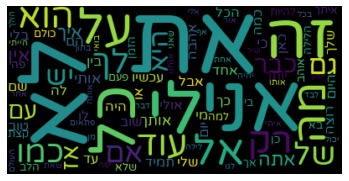

Most common tokens in טוליק (Bag-of-Words representation):
['טוליק', 'יושב', 'לו', 'של', 'הים', 'מביט', 'בחול', 'בשקט', 'על', 'הוא', 'הכחול', 'ענבים', 'כמעט', 'בעיניים', 'בחולות', 'מותר', 'לה', 'נעלב', 'כי', 'הלכה', 'הי', 'שותק', 'העינב', 'בנחת', 'כל', 'לאכול', 'העיניים', 'אשכול', 'לי', 'דמעות', 'רק', 'עגולות', 'לטוליק', 'תן', 'האשכול', 'שני', 'אוכל', 'אך', 'כוכבים', 'לבד', 'רינה', 'עינב']


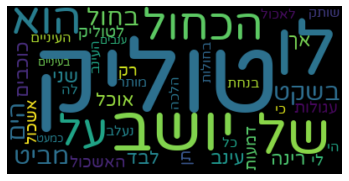

In [152]:
print("Most common tokens (Bag-of-Words representation):")
print([vocabulary[l] for l in bow_inx[::-1]])
bow_text= ""
for w in bow_inx:
    bow_text += (vocabulary[w][::-1]+" w ") * bow_by_words[0,w]

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(bow_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("Most common tokens in טוליק (Bag-of-Words representation):")
bow_inx_tulik = np.argsort(tulik_bow.sum(axis=0)).tolist()[0][-tulik_sow.sum():]
print([vocabulary[l] for l in bow_inx_tulik[::-1]])
bow_text= ""
for w in bow_inx_tulik:
    bow_text += (vocabulary[w][::-1]+" w ") * tulik_bow.sum(axis=0)[0,w]

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(bow_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Set-of-Words Cloud
The second diagram represents the most common unique tokens (without repetitions), using the Set-of-Words representation.
How should a tag cloud for one song look like using the SoW representation?
Notice how the word `לי` was number 4 on the BoW list but number 6 on SoW?
The usage of the word might be more repetitive than song-wise-common, meaning the songs that used it, used it many times, which made it climb the BoW index.

Most common unique tokens (Set-of-Words representation):
['את', 'לא', 'אני', 'כל', 'על', 'לי', 'זה', 'רק', 'מה', 'אל', 'עוד', 'של', 'כמו', 'גם', 'לך', 'אם', 'כבר', 'עם', 'הוא', 'אז', 'יש', 'אין', 'איך', 'כי', 'כך', 'אותך', 'עד', 'הכל', 'אותי', 'עכשיו', 'היא', 'אבל', 'שוב', 'תמיד', 'אחד', 'אתה', 'שלי', 'לו', 'מי', 'שם', 'בלי', 'אולי', 'רוצה', 'אהבה', 'או', 'היום', 'יום', 'יותר', 'כאן', 'בין', 'שלא', 'היה', 'הלב', 'שלך', 'להיות', 'כמה', 'הם', 'אך', 'טוב', 'הזמן', 'לה', 'איתך', 'פתאום', 'בתוך', 'פעם', 'קצת', 'בי', 'פה', 'יודע', 'יפה', 'בכל', 'בא', 'אוהב', 'לבד', 'אחר', 'כולם', 'כן', 'אלי', 'הלילה', 'דבר', 'אור', 'יהיה', 'מן', 'העולם', 'אף', 'אותו', 'למה', 'שאת', 'שאני', 'אחת', 'יכול', 'מקום', 'לנו', 'איתי', 'אותה', 'הולך', 'שיר', 'בך', 'מול', 'החיים']


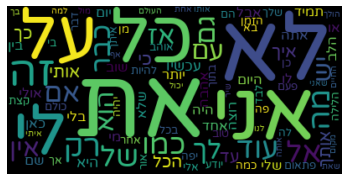

In [153]:
print("Most common unique tokens (Set-of-Words representation):")
print([vocabulary[l] for l in sow_inx[::-1]])
sow_text= ""
for w in sow_inx:
    sow_text += (vocabulary[w][::-1]+" w ") * sow_by_words[0,w]

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(sow_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### it-idf Cloud
The third diagram represents the most 'important' words, using the tf-idf representation.
First in the entire corpus and then in `טוליק`.
Notice how the word `הים` was number 5 on the BoW representation of `טוליק` but number 15(!!!) on the tf-idf representation?


Most 'important' tokens (tf-idf representation):
['את', 'לא', 'אני', 'לי', 'זה', 'כל', 'על', 'מה', 'רק', 'אל', 'לך', 'עוד', 'כמו', 'אם', 'של', 'הוא', 'יש', 'כבר', 'גם', 'אותך', 'אין', 'איך', 'אז', 'היא', 'אתה', 'עם', 'אותי', 'כי', 'הכל', 'כך', 'עד', 'שלי', 'עכשיו', 'שוב', 'תמיד', 'רוצה', 'מי', 'לו', 'אחד', 'אבל', 'אולי', 'אהבה', 'שם', 'בלי', 'כמה', 'יום', 'איתך', 'או', 'שלך', 'היום', 'לה', 'יותר', 'היה', 'כאן', 'הלב', 'טוב', 'להיות', 'בין', 'שלא', 'בי', 'הם', 'פעם', 'אוהב', 'הזמן', 'אך', 'בתוך', 'בא', 'הלילה', 'יודע', 'יפה', 'פה', 'לבד', 'קצת', 'אלי', 'פתאום', 'כן', 'כולם', 'למה', 'שאת', 'בכל', 'יהיה', 'אחר', 'דבר', 'אור', 'הייתי', 'שאני', 'יכול', 'העולם', 'איתי', 'שיר', 'אף', 'בך', 'הולך', 'אותה', 'לנו', 'מקום', 'אותו', 'לילה', 'אחת', 'מן']


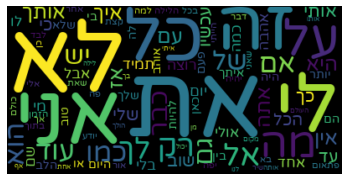

Most 'important' tokens in טוליק (tf-idf representation):
['טוליק', 'יושב', 'הכחול', 'האשכול', 'העינב', 'לטוליק', 'בחול', 'עגולות', 'עינב', 'אשכול', 'מביט', 'נעלב', 'בשקט', 'ענבים', 'רינה', 'לו', 'בחולות', 'בנחת', 'הים', 'לאכול', 'הי', 'הלכה', 'מותר', 'שותק', 'העיניים', 'כוכבים', 'דמעות', 'אוכל', 'בעיניים', 'תן', 'של', 'שני', 'כמעט', 'הוא', 'לבד', 'לה', 'אך', 'על', 'כי', 'רק', 'לי', 'כל']


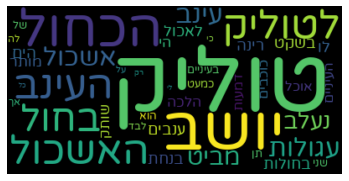

In [154]:
print("Most 'important' tokens (tf-idf representation):")
print([vocabulary[l] for l in tfidf_inx[::-1]])
tfidf_text= ""
for w in tfidf_inx:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*tfidf_by_words[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("Most 'important' tokens in טוליק (tf-idf representation):")
tfidf_inx_tulik = np.argsort(tulik_tfidf.mean(axis=0)).tolist()[0][-tulik_sow.sum():]
print([vocabulary[l] for l in tfidf_inx_tulik[::-1]])
tfidf_text= ""
for w in tfidf_inx_tulik:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*tulik_tfidf.mean(axis=0)[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Stop! Words!
Take a look at the following diagrams and lists of most important words

Most 'important' tokens of Aviv Geffen (tf-idf representation):
['את', 'לא', 'זה', 'אני', 'לי', 'אותך', 'לך', 'אתה', 'רק', 'אז', 'אותי', 'כבר', 'עכשיו', 'אם', 'אבל', 'מה', 'אוהב', 'אל', 'יותר', 'כל', 'שוב', 'הוא', 'עם', 'עוד', 'שאני', 'לו', 'כך', 'של', 'יש', 'על', 'הם', 'תמיד', 'איך', 'כי', 'אחד', 'גם', 'כמו', 'כמה', 'שאת', 'אנחנו', 'עד', 'בא', 'רוצה', 'האם', 'תני', 'לבד', 'לנו', 'קשה', 'שלא', 'הולך', 'שלך', 'רציתי', 'שלום', 'שם', 'יהיה', 'בוכה', 'פעם', 'לה', 'בורח', 'בתוך', 'אהבה', 'לראות', 'להיות', 'איש', 'קצת', 'רוצים', 'עניין', 'היה', 'היא', 'הרבה', 'כולם', 'שלי', 'מדי', 'פה', 'אור', 'מי', 'למה', 'טוב', 'בלי', 'הדמעות', 'האור', 'רואה', 'אולי', 'אין', 'הלב', 'נגמר', 'מאוד', 'אך', 'מישהו', 'אבא', 'היית', 'חבר', 'נראה', 'מתים', 'יפה', 'היום', 'הזמן', 'בסוף', 'יודעת', 'נהיה']


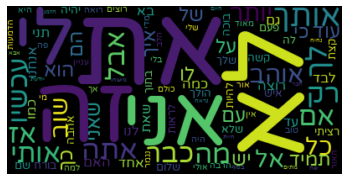

Most 'important' tokens of Eyal Golan (tf-idf representation):
['את', 'לי', 'אני', 'לך', 'רק', 'לא', 'אותך', 'כל', 'זה', 'מה', 'איך', 'כמו', 'אל', 'הלב', 'הכל', 'אם', 'אלייך', 'כבר', 'שאת', 'שלי', 'אותי', 'עוד', 'אוהב', 'יש', 'על', 'של', 'גם', 'אהבה', 'איתך', 'שלך', 'אין', 'שוב', 'כמה', 'תמיד', 'רוצה', 'עכשיו', 'אז', 'היא', 'יום', 'כי', 'לבד', 'בי', 'לה', 'בך', 'אלי', 'תני', 'תגידי', 'היום', 'יפה', 'הלילה', 'אולי', 'עם', 'עד', 'להיות', 'יכול', 'עלייך', 'כאן', 'מי', 'שלא', 'העולם', 'יותר', 'יודע', 'איתי', 'כולם', 'אותה', 'בכל', 'היית', 'אחד', 'יודעת', 'הוא', 'בלב', 'פה', 'בעולם', 'שאני', 'בלילות', 'או', 'קצת', 'כשאת', 'בואי', 'קשה', 'הזמן', 'כואב', 'עלי', 'לו', 'לאהוב', 'חושב', 'החיים', 'למה', 'ביחד', 'מחכה', 'ליבך', 'בשבילי', 'כך', 'בלעדייך', 'חיי', 'אלוהים', 'חלום', 'הכי', 'תלכי', 'בית']


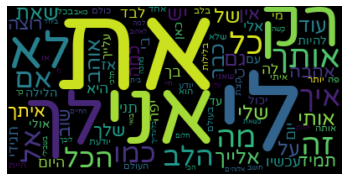

In [155]:
geffen_tfidf = tfidf_train[train_df.index[train_df['artist'] == "אביב גפן"].tolist()]
geffen_tfidf_by_words = geffen_tfidf.mean(axis=0)
geffen_tfidf_inx = np.argsort(geffen_tfidf_by_words).tolist()[0][-k_best_words:]

print("Most 'important' tokens of Aviv Geffen (tf-idf representation):")
print([vocabulary[l] for l in geffen_tfidf_inx[::-1]])
tfidf_text= ""
for w in geffen_tfidf_inx:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*geffen_tfidf_by_words[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

golan_tfidf = tfidf_train[train_df.index[train_df['artist'] == "אייל גולן"].tolist()]
golan_tfidf_by_words = golan_tfidf.mean(axis=0)
golan_tfidf_inx = np.argsort(golan_tfidf_by_words).tolist()[0][-k_best_words:]

print("Most 'important' tokens of Eyal Golan (tf-idf representation):")
print([vocabulary[l] for l in golan_tfidf_inx[::-1]])
tfidf_text= ""
for w in golan_tfidf_inx:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*golan_tfidf_by_words[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The same happens with
`יהודה פוליקר` and `משה פרץ`
`יהודית רביץ` and `זהבה בן`
`מאיר אריאל` and `ליאור נרקיס`
The pronounces (`את`,`אני`,`אתה`,etc.) the direct object marker (`אֵת`) and other syntax words and markers *take over* the vocabulary of most artists, even with tf-idf.
It is common for some NLP-tasks to remove the so called "Stop-Words" from the texts representations for this exact reason - this will be very useful with kNN.
We will discard the most common words using the BoW representation.

In [156]:
vocabulary = list(set(vocabulary) - set([vocabulary[l] for l in bow_inx[:51:-1]]))
print(f"Vocabulary length is: {len(vocabulary)}")
vectorizer_bow = CountVectorizer(vocabulary=vocabulary)
BoW_train = vectorizer_bow.fit_transform(train_df.lyrics)
print(f"The size of the vocabulary is indeed: {len(vectorizer_bow.get_feature_names_out())}")
vectorizer_sow = CountVectorizer(vocabulary=vocabulary, binary=True)
SoW_train = vectorizer_sow.fit_transform(train_df.lyrics)
vectorizer_tfidf = TfidfVectorizer(vocabulary=vocabulary,sublinear_tf=True)
tfidf_train = vectorizer_tfidf.fit_transform(train_df.lyrics)
bow_by_words = BoW_train.sum(axis=0)
sow_by_words = SoW_train.sum(axis=0)
tfidf_by_words = tfidf_train.mean(axis=0)
bow_inx = np.argsort(bow_by_words).tolist()[0][-k_best_words:]
sow_inx = np.argsort(sow_by_words).tolist()[0][-k_best_words:]
tfidf_inx = np.argsort(tfidf_by_words).tolist()[0][-k_best_words:]

Vocabulary length is: 57149
The size of the vocabulary is indeed: 57149


And now it's much better:

Most 'important' tokens of Yehuda Poliker (tf-idf representation):
['אוהב', 'יותר', 'שאני', 'הם', 'שאת', 'בא', 'אנחנו', 'תני', 'האם', 'לבד', 'שלא', 'קשה', 'לנו', 'הולך', 'שלך', 'רציתי', 'שלום', 'יהיה', 'בוכה', 'פעם', 'בורח', 'בתוך', 'אהבה', 'להיות', 'לראות', 'איש', 'רוצים', 'קצת', 'עניין', 'מדי', 'כולם', 'הרבה', 'פה', 'למה', 'אור', 'טוב', 'הדמעות', 'האור', 'רואה', 'הלב', 'מישהו', 'נגמר', 'מאוד', 'אך', 'אבא', 'היית', 'חבר', 'נראה', 'יפה', 'היום', 'הזמן', 'מתים', 'יודעת', 'בסוף', 'אלי', 'נהיה', 'ביחד', 'תשכח', 'עלייך', 'כאן', 'גדול', 'לאהוב', 'עצוב', 'לנצח', 'מעט', 'שזה', 'כמעט', 'כן', 'זמן', 'אמרת', 'אחרי', 'בלילה', 'תברח', 'לחלום', 'לעולם', 'בי', 'אנשים', 'אותה', 'יודע', 'לפעמים', 'שכואב', 'חזק', 'כאב', 'ילד', 'למות', 'חושב', 'חוזר', 'הכי', 'אנ', 'כותב', 'בכל', 'מחר', 'איתי', 'הולכת', 'לומר', 'עדיף', 'הייתי', 'בואי', 'אף', 'אנו']


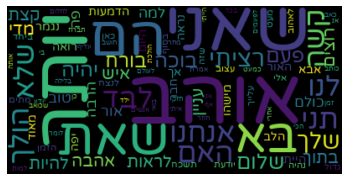

Most 'important' tokens of Eyal Golan (tf-idf representation):
['הלב', 'אלייך', 'שאת', 'אוהב', 'איתך', 'אהבה', 'שלך', 'לבד', 'בי', 'בך', 'אלי', 'תני', 'תגידי', 'היום', 'יפה', 'הלילה', 'להיות', 'יכול', 'עלייך', 'כאן', 'שלא', 'העולם', 'יודע', 'יותר', 'איתי', 'כולם', 'אותה', 'בכל', 'היית', 'יודעת', 'בלב', 'פה', 'בעולם', 'שאני', 'בלילות', 'כשאת', 'קצת', 'בואי', 'קשה', 'הזמן', 'כואב', 'עלי', 'חושב', 'לאהוב', 'למה', 'ביחד', 'בשבילי', 'החיים', 'ליבך', 'מחכה', 'בלעדייך', 'חיי', 'הכי', 'אלוהים', 'חלום', 'תלכי', 'לילה', 'בית', 'פתאום', 'בלילה', 'יושב', 'הייתי', 'בין', 'אהבתי', 'אוהבת', 'זו', 'קורא', 'רציתי', 'אחת', 'לעולם', 'אחר', 'לאן', 'ממך', 'מול', 'הזה', 'שיש', 'רוקדת', 'אחרת', 'פזמון', 'אך', 'דבר', 'חזק', 'מילה', 'מאוהב', 'שר', 'נערה', 'אתן', 'לומר', 'מילים', 'מכל', 'ימים', 'נשאר', 'האהבה', 'סתם', 'הנשמה', 'פשוט', 'תחזרי', 'אצלך', 'טוב', 'בסוף']


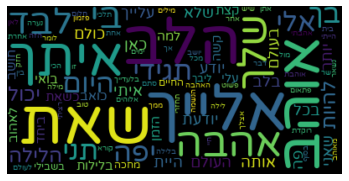

In [157]:
geffen_tfidf = tfidf_train[train_df.index[train_df['artist'] == "אביב גפן"].tolist()]
geffen_tfidf_by_words = geffen_tfidf.mean(axis=0)
geffen_tfidf_inx = np.argsort(geffen_tfidf_by_words).tolist()[0][-k_best_words:]

print("Most 'important' tokens of Yehuda Poliker (tf-idf representation):")
print([vocabulary[l] for l in geffen_tfidf_inx[::-1]])
tfidf_text= ""
for w in geffen_tfidf_inx:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*geffen_tfidf_by_words[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

golan_tfidf = tfidf_train[train_df.index[train_df['artist'] == "אייל גולן"].tolist()]
golan_tfidf_by_words = golan_tfidf.mean(axis=0)
golan_tfidf_inx = np.argsort(golan_tfidf_by_words).tolist()[0][-k_best_words:]

print("Most 'important' tokens of Eyal Golan (tf-idf representation):")
print([vocabulary[l] for l in golan_tfidf_inx[::-1]])
tfidf_text= ""
for w in golan_tfidf_inx:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*golan_tfidf_by_words[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Being Normal
For the BoW and SoW representations the vectors should be normalized.
We used the StandardScaler for standardize features by removing the mean and scaling to unit variance.
The with_mean var is set to false because centering a sparce matrix results in building a dense matrix which in common use cases is likely to be too large to fit in memory.

In [158]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
scaler.fit(BoW_train)
BoW_train = scaler.transform(BoW_train)
scaler = StandardScaler(with_mean=False)
scaler.fit(SoW_train)
SoW_train = scaler.transform(SoW_train)

## Keep Your Distance
How can we define how 'close' two songs are?
In order to do so we will need a method for measuring the distance between two texts based on their representations.
We will use three, and choose one using the validation set:
* [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)
* [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)
* [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity)

In [159]:
from scipy.spatial import distance
songs_to_comapre = ["זיקוקים","שמים","לא יכול להוריד ממך את העיניים"]
distance_to_use = {"Hamming distance":distance.hamming, "Euclidean distance":distance.euclidean, "cosine distance": distance.cosine}
for d_n,d_f in distance_to_use.items():
    for s1 in range(len(songs_to_comapre)):
        for s2 in range(s1 + 1,len(songs_to_comapre)):
            first_song = train_df.index[train_df['song_name'] == songs_to_comapre[s1]]
            second_song = train_df.index[train_df['song_name'] == songs_to_comapre[s2]]
            print(f"The {d_n} between {songs_to_comapre[s1]} and {songs_to_comapre[s2]} using the tf-idf representation:")
            print(d_f(tfidf_train[first_song].toarray()[0],tfidf_train[second_song].toarray()[0]))

The Hamming distance between זיקוקים and שמים using the tf-idf representation:
0.0019072949657911774
The Hamming distance between זיקוקים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
0.00218726486902658
The Hamming distance between שמים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
0.002362246058548706
The Euclidean distance between זיקוקים and שמים using the tf-idf representation:
1.411564108007998
The Euclidean distance between זיקוקים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
1.4142135623730951
The Euclidean distance between שמים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
1.3995854007561623
The cosine distance between זיקוקים and שמים using the tf-idf representation:
0.9962566155082073
The cosine distance between זיקוקים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
1.0
The cosine distance between שמים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
0.9

## A story of One-vs-All, kNN, Eyal Golan and Aviv Geffen
We will now build our first classifier!
Our first classifier will be "One-vs-All"; Our job is to differentiate between songs of one particular artist and all the rest.
We will actually build two classifiers, [one for Eyal Golan and one for Aviv Geffen](https://he.wikipedia.org/wiki/%D7%90%D7%91%D7%99%D7%91_%D7%90%D7%95_%D7%90%D7%99%D7%99%D7%9C).